[0.0024368362926355763, 0.0023649976349430293, 0.00036967861192332003, 0.001698298589606252, 0.003790336189623892, 0.007295759515478389, 0.015163844519818757, 0.01745200370859934, 0.019883114399389994, 0]


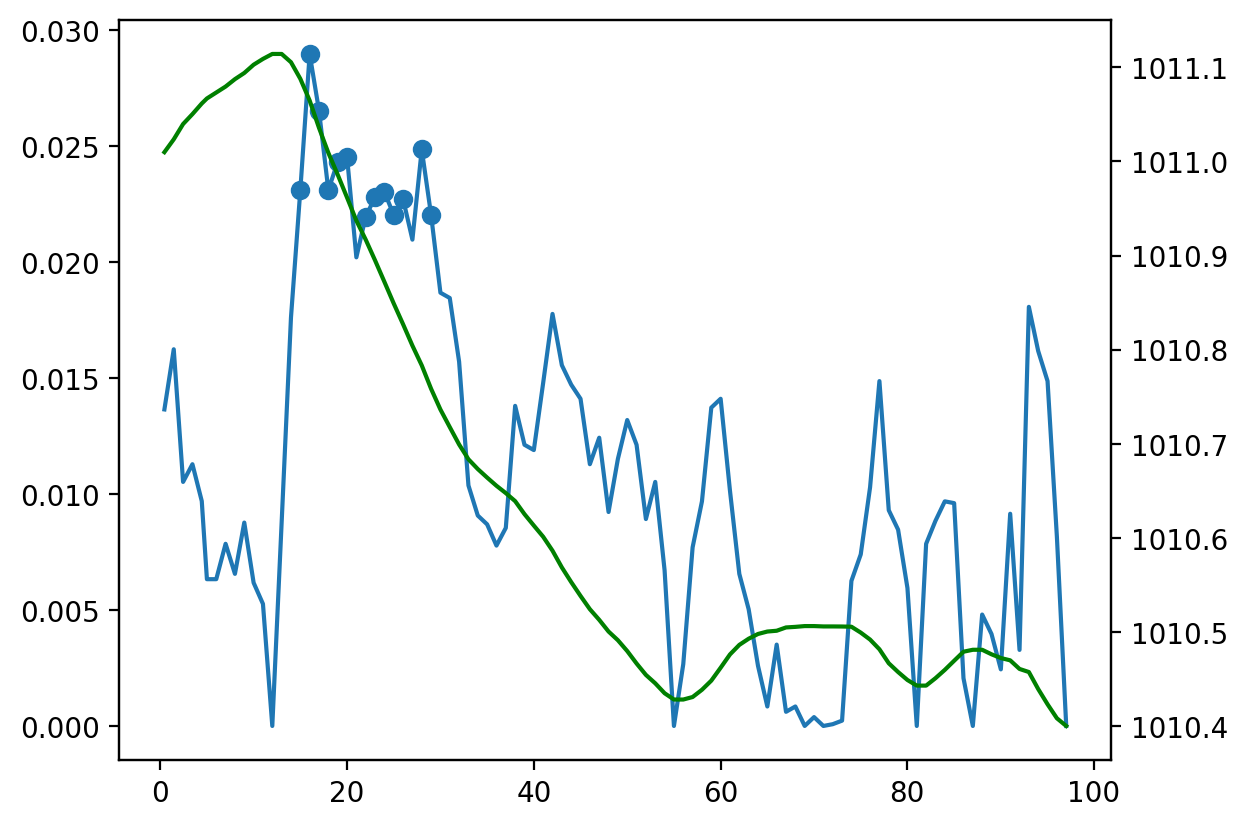

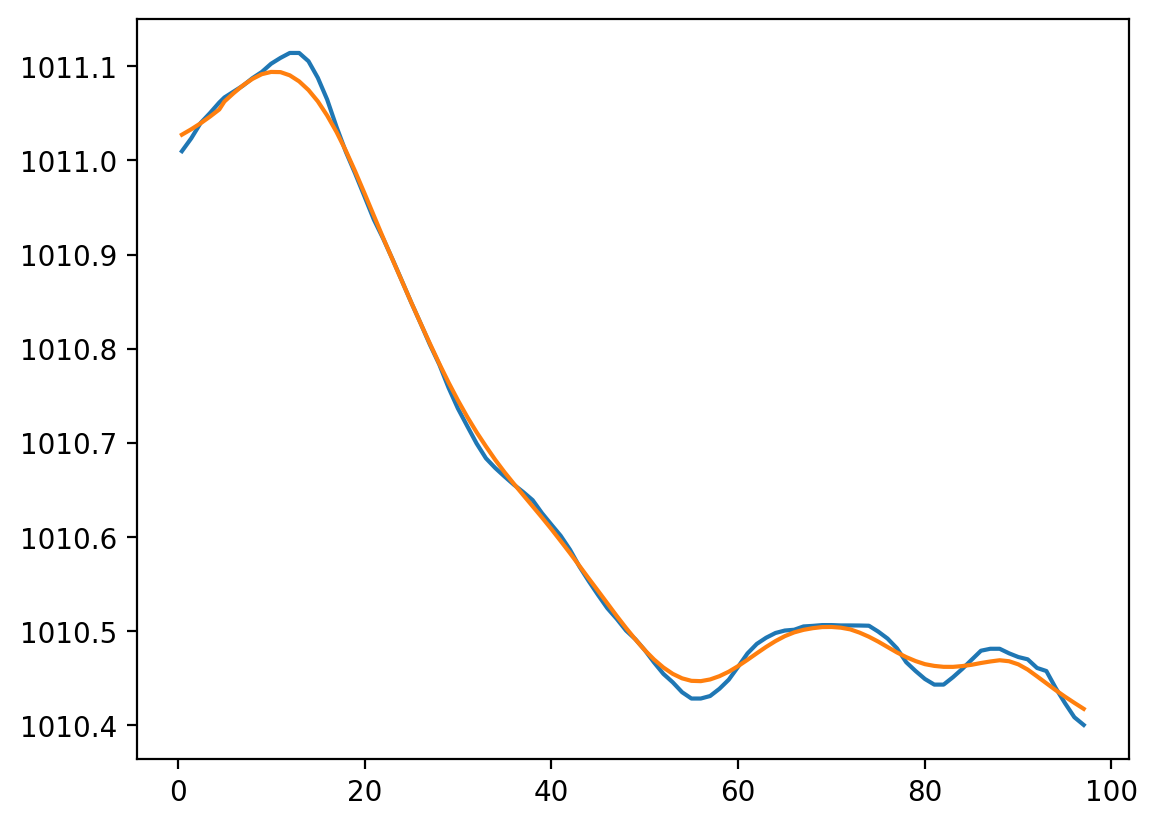

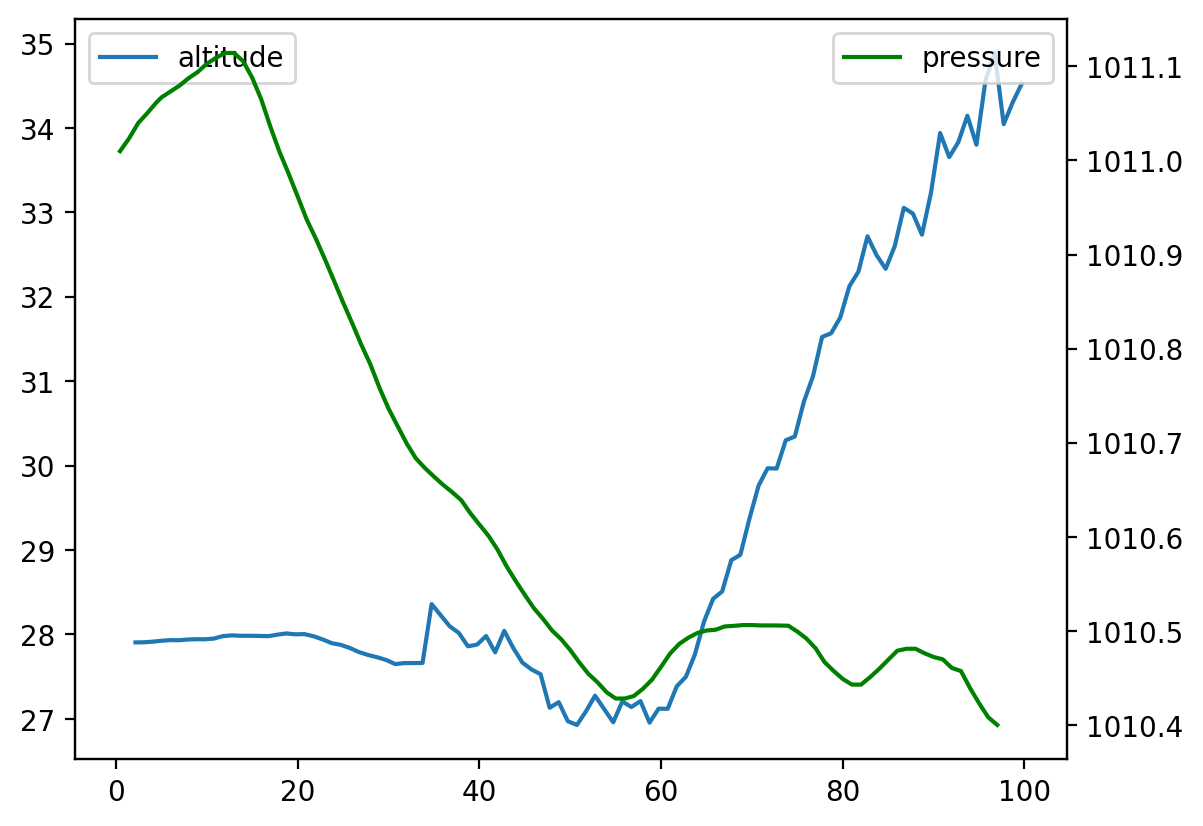

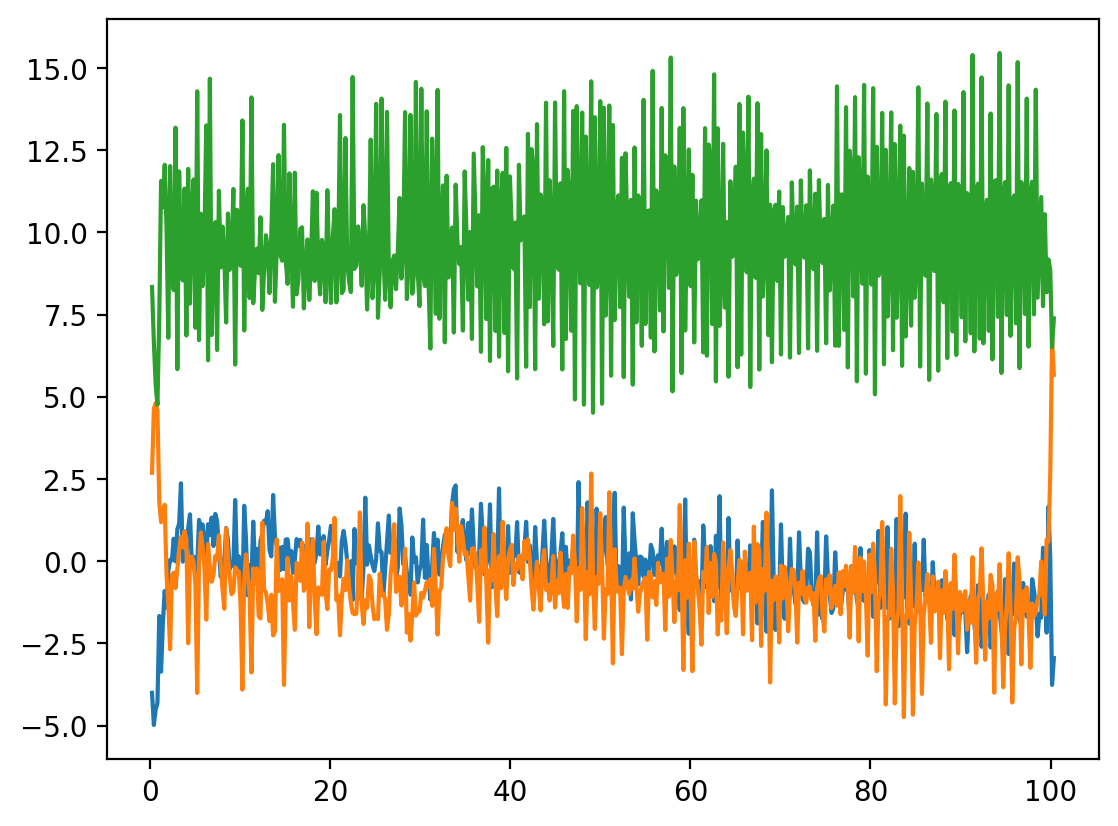

0.02897522334558583
0.0
0.01075914744446569
0.01075914744446569
0.020973154760029197
False


In [39]:
import pandas as pd #package for reading data
import numpy as np
import graphlib
import statistics
import matplotlib.pyplot as plt #package for plots
import gmplot 
from scipy import signal



#main function
def der(x,y):
  """
  derivative of column y of sheet x
  """
  i = 0
  time = x['time']
  #value = reduce_bar
  value = x[y]
  slopes = []
  aslopes = []
  times = []

  while i < len(x)-1: 
    x0, x1 = time.iat[i], time.iat[i+1]
    t = time.iat[i]
    y0, y1 = value[i], value[i+1]
    numerator = y1-y0
    num = numerator
    if numerator < 0 :  # somehow abs() doesn't work
      numerator *= -1
    slope = numerator/(x1-x0)
    #slope = numerator
    aslope = num /(x1-x0)
    #aslope = num
    slopes.append(slope)
    times.append(t)
    aslopes.append(aslope)
    i+=1
  slopes.append(0)
  times.append(0)
  aslopes.append(0)
  return [slopes,times,aslopes]

#data 
gps_data = pd.read_csv('GPS.csv')
pressure_data = pd.read_csv('Pressure.csv')
pressure_range = pd.read_csv("Pressure_Range.csv")
acceleration_data = pd.read_csv("Acceleration.csv")
# gps_data = pd.read_csv('hills_gps.csv')
# pressure_data = pd.read_csv('hills_p.csv')

latitude = gps_data["Latitude"]
longitude = gps_data["Longitude"]
gps_time = gps_data["time"]
altitude = gps_data["Altitude"]

pressure_r = pressure_range["Pressure"]
pressure_r_t = pressure_range["time"]
deri_pr = der(pressure_range,"Pressure")
der_pr = deri_pr[0]
der_prt = deri_pr[1]
print(der_pr)

bar = pressure_data["Pressure"]
bar_time = pressure_data["time"]
reduce_bar = signal.savgol_filter(bar,window_length=11, polyorder=1, mode="nearest")
deri = der(pressure_data,'Pressure')
der_p = deri[0]
der_t = deri[1]
der_a = deri[2]

a_x = acceleration_data["Acceleration x"]
az =acceleration_data["Acceleration z"]
ay = acceleration_data["Acceleration y"]
at = acceleration_data["time"]



# range determination
mean = statistics.mean(der_p)
std = statistics.stdev(der_p)
range =  der_p[0] + std
#range = der_pr[0]

# Gathering elevated Data
range_p = []
range_p_flat = []
range_t = []
range_t_flat = []
range_a = []
range_a_flat = []
for i in der_p:
  if i >= range:
    range_p.append(i)
    range_t.append(der_t[der_p.index(i)])
    range_a.append(der_a[der_p.index(i)])
  else:
    range_p_flat.append(i)
    range_t_flat.append(der_t[der_p.index(i)])
    range_a_flat.append(der_a[der_p.index(i)])

# for n in range_a:
#   if n > 0 :
#     print("u")
#     print(n)
#   else:
#     print("d")
#     print(n)
up_time = []
down_time = []
for n in range_a:
  if n < 0:
    up_time.append(range_t[range_a.index(n)])
  else:
    down_time.append(range_t[range_a.index(n)])


#Plotting data
fig, ax = plt.subplots()
fig.set_dpi(200)
# ax.plot(abs_t,abs)
ax.plot(bar_time,der_p)
ax.scatter(range_t,range_p)
ax2 = ax.twinx()
ax2.plot(bar_time,bar,color='green')
plt.show()

fig1, ax1 = plt.subplots()
fig1.set_dpi(200)
ax1.plot(bar_time,bar)
ax1.plot(bar_time,reduce_bar)
plt.show()

fig2, ax3 = plt.subplots()
fig2.set_dpi(200)
ax3.plot(gps_time,altitude, label="altitude")
ax3.legend()
ax4 = ax3.twinx()
ax4.plot(bar_time,bar,color='green',label="pressure")
ax4.legend()
plt.show()

fig3 ,ax5 = plt.subplots()
fig3.set_dpi(200)
ax5.plot(at,a_x,label="x")
ax5.plot(at,ay,label="y")
ax5.plot(at,az,label="z")
plt.legend()
plt.show()

#Gathering co-ordinates of elevated data
def gather_function(time_data,data1,data2):
        i = 0
        x = 0
        while i < len(time_data) - 1:
            for n in gps_time:
                if(time_data[i] <= n <=time_data[i+1]):
                    data1.append(latitude[x])
                    data2.append(longitude[x])
                    x = x + 1
            i = i + 1 
        return [data1,data2]
        
gps_hill_la = []
gps_hill_lo = []
up_la = []
down_lo = []
up_lo = []
down_la = []
gps = gather_function( range_t,gps_hill_la, gps_hill_lo)
up = gather_function( up_time,up_la, up_lo)
down = gather_function(down_time, down_la, down_lo)
# for i in range_t:
#   for n in gps_time:
#     if (i <= n <= ):
#       gps_hill_la.append(latitude[range_t.index(i)])
#       gps_hill_lo.append(longitude[range_t.index(i)])
# there might be an issue in co-ordinate selection

#making the map
lat = latitude.iat[0]
log = longitude.iat[0]

gmap = gmplot.GoogleMapPlotter(lat, log, zoom=18)
gmap.plot(latitude, longitude, '#771c2f', size = 0.5, marker = False )
gmap.marker(latitude[0],longitude[0], color='cornflowerblue')
# gmap.scatter(gps_hill_la, gps_hill_lo, '#16EBF9', size = 0.5, marker = False  )
gmap.scatter(up_la, up_lo, '#FFFF00', size = 0.5, marker = False  )
gmap.scatter(down_la, down_lo, '#16EBF9', size = 0.5, marker = False  )



# uphill is yellow
# dwonhill is blue 

gmap.draw( "mapping.html" )

#debugging



print(max(der_p) - min(der_p))
print(min(der_p))
print(mean)
print(mean - min(der_p))
print(range)
#print(mean(bar))
print(std > max(der_pr))

